In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
import re 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

# **Load Data**

In [2]:
data=pd.read_csv('../input/twitter-entity-sentiment-analysis/twitter_training.csv', sep=',', names=['Tweet_ID','Entity','Sentiment','Tweet_content'])

# Data Exploration

In [3]:
data.shape

(74682, 4)

In [4]:
data.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


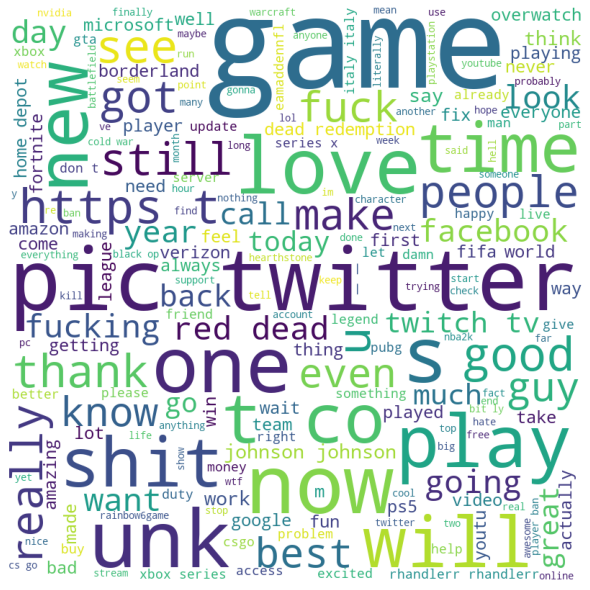

In [6]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in data["Tweet_content"]:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

([<matplotlib.patches.Wedge at 0x7f5178e69790>,
 [Text(-0.8936408809046303, 0.6414093669225578, 'Negative'),
  Text(-0.39649770564254117, -1.0260553442286633, 'Positive'),
  Text(1.0532293937999033, -0.3173449921392938, 'Neutral'),
  Text(0.5716146417662045, 0.9398173765782871, 'Irrelevant')],
 [Text(-0.4874404804934347, 0.3498596546850315, '30.2%'),
  Text(-0.21627147580502246, -0.5596665513974527, '27.9%'),
  Text(0.5744887602544927, -0.17309726843961476, '24.5%'),
  Text(0.31178980459974787, 0.5126276599517929, '17.4%')])

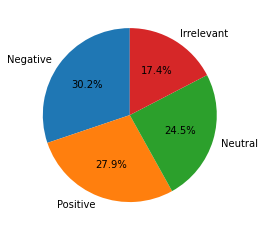

In [7]:
plt.pie(data["Sentiment"].value_counts()
,labels=['Negative','Positive','Neutral','Irrelevant'],autopct='%1.1f%%',startangle=90)

In [9]:
data["Sentiment"].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64

# Data Preprocessing

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
data.isnull().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

In [10]:
data.dropna(axis=0, inplace=True)

In [11]:
data.isnull().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       73996 non-null  int64 
 1   Entity         73996 non-null  object
 2   Sentiment      73996 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [13]:
data.reset_index(inplace=True)

In [14]:
#Clean the text
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [15]:
x = data['Tweet_content'].apply(lambda p: clean_text(p))

In [16]:
import re 
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
#1
def reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    
    return reviews
#2
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words
#3
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

In [17]:
y =data['Sentiment']

In [18]:
#1
reviewtweet = reviews(x)
#2
no_stop_words_tweet = remove_stop_words(reviewtweet)
#3
stemmed_reviews_tweet = get_stemmed_text(no_stop_words_tweet)

In [19]:
stemmed_reviews_tweet[20]

'first borderland session long time actual realli satisfi combat experi . got realli good kill'

# Encoding

In [20]:
max_words = 8000


tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(stemmed_reviews_tweet)
x = tokenizer.texts_to_sequences(stemmed_reviews_tweet)
x = pad_sequences(x, maxlen = 300)

In [21]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

y = np.array(label_tokenizer.texts_to_sequences(y))

# Model

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8)

In [23]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 128, input_length = 300))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(128, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(128, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

2022-12-28 11:38:25.987276: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
history = model_lstm.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test) , 
    epochs = 1,
    batch_size = 512
)

2022-12-28 11:38:38.059554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


116/116 [==============================] - 561s 5s/step - loss: 1.2577 - accuracy: 0.4390 - val_loss: 1.0194 - val_accuracy: 0.5864
